I removed the results after using pandas_profiling library for initial commit on Github

In [1]:
# pip install pandas_profiling

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
from math import sqrt
from tqdm import tqdm
# from scipy import stats
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

After I import necessary libraries I open train.csv file as pandas Dataframe and display basic information

In [3]:
data = pd.read_csv('C:/Users/Alex/Documents/тестовые задания/MacPawInternship/msi2021-data-science-main/data/train.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

I use pandas_profiling to quickly assess the data, get some initial insights, find out features with lots of missing values

In [4]:
# pandas_profiling.ProfileReport(data)

I start from looking more closely at the target feature, 'SalePrice'

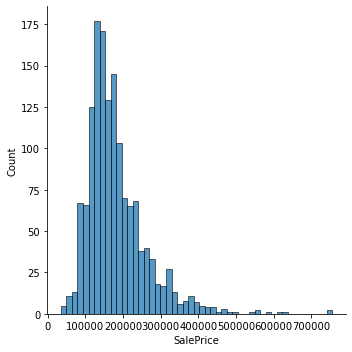

In [5]:
sns.displot(data.SalePrice)

Since the target variable is not normally distributed (it is right-skewed), it is better to predict the logged target. Below is the distribution of the logged SalePrice.

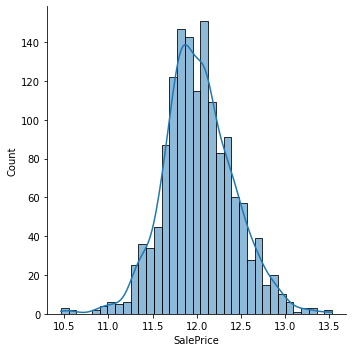

In [6]:
sns.displot(np.log1p(data.SalePrice), kde = True)

Drawing upon the pandas profiling report I would get rid of the features that contain more than 50% missing values or zeros (for continuous features), i.e.:
Alley has 1369 (93.8%) missing values

PoolQC has 1453 (99.5%) missing values

Fence has 1179 (80.8%) missing values

MiscFeature has 1406 (96.3%) missing values

MasVnrArea has 861 (59.0%) zeros

BsmtFinSF2 has 1293 (88.6%) zeros

2ndFlrSF has 829 (56.8%) zeros

LowQualFinSF has 1434 (98.2%) zeros

WoodDeckSF has 761 (52.1%) zeros

EnclosedPorch has 1252 (85.8%) zeros

3SsnPorch has 1436 (98.4%) zeros

ScreenPorch has 1344 (92.1%) zeros

PoolArea has 1453 (99.5%) zeros

MiscVal has 1408 (96.4%) zeros

I examine relationship of the target and some numerical variables:

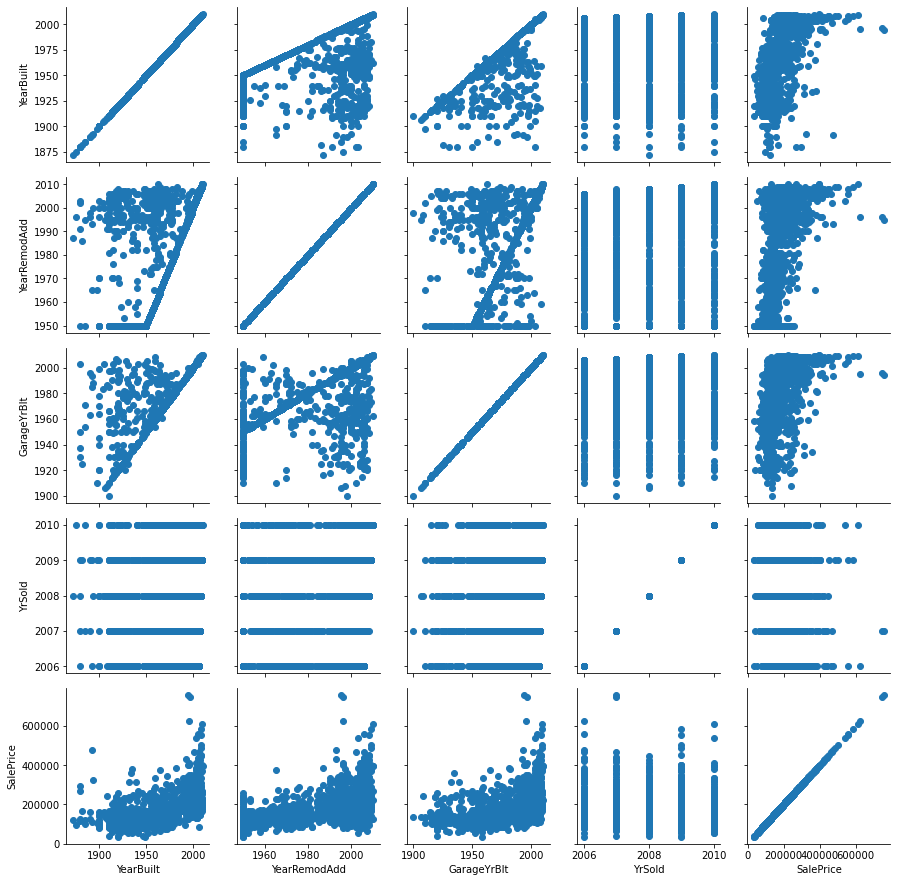

In [7]:
pair_grid_plot = sns.PairGrid(data.loc[:, ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold', 'SalePrice']])
pair_grid_plot.map(plt.scatter)

After examining relationship between target and property age features using scatter plots, I would definitely leave out 'YrSold'.

In [8]:
data.loc[0:5, ['1stFlrSF', '2ndFlrSF', 'GrLivArea']]

,1stFlrSF,2ndFlrSF,GrLivArea
0,856,854,1710
1,1262,0,1262
2,920,866,1786
3,961,756,1717
4,1145,1053,2198
5,796,566,1362


Since 'GrLivArea' represents sum of the 1st and 2nd floors areas ('1stFlrSF', '2ndFlrSF'), I'll keep only 'GrLivArea'.
Let's look at correlation heatmap. Other numerical features (excluding those with lots of zeros), which characterize different areas of the property are added: Number of bedrooms, bathrooms, number of kitchens, total number of rooms and number of fireplaces.

<AxesSubplot:>

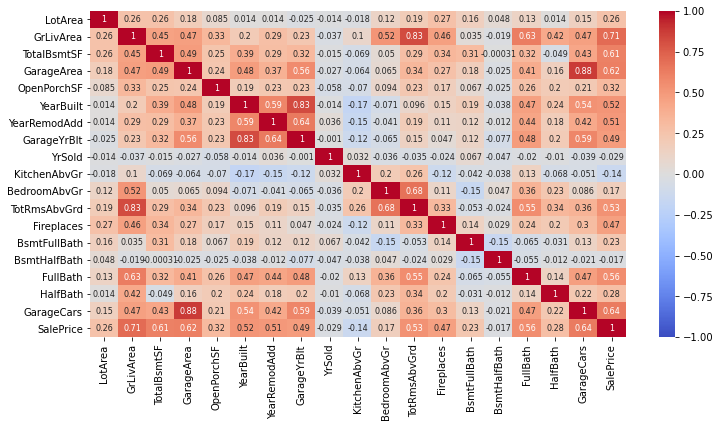

In [9]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.loc[:, ['LotArea', 'GrLivArea', 'TotalBsmtSF', 'GarageArea', 'OpenPorchSF', 'YearBuilt', 'YearRemodAdd', 
                         'GarageYrBlt', 'YrSold', 'KitchenAbvGr', 'BedroomAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
                         'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'GarageCars', 'SalePrice']].corr(), 
            vmin=-1, vmax=1, annot=True, annot_kws={"size":8}, cmap='coolwarm')

Features 'GrLivArea', 'TotalBsmtSF', 'GarageArea', 'YearBuilt' are a good choice for the model, as they have a strong correlation with the target feature. As i have already mentioned, 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt' have a strong relationship with each other (they are highly collinear), so it's better to keep only 'YearBuilt'. Surprisingly LotArea has a pretty weak correlation with 'SalePrice'. I decided to keep only features that have > 0.5 correlation with the target. Since correlation between 'GarageCars' and 'GarageArea', 'TotRmsAbvGrd' and 'GrLivArea', 'FullBath' and 'GrLivArea' is more than 0.6, I'll keep only 'GarageArea' and 'GrLivArea'.

We may explore closely the relationship between the target and 'GrLivArea' variable, because they have the strongest correlation.

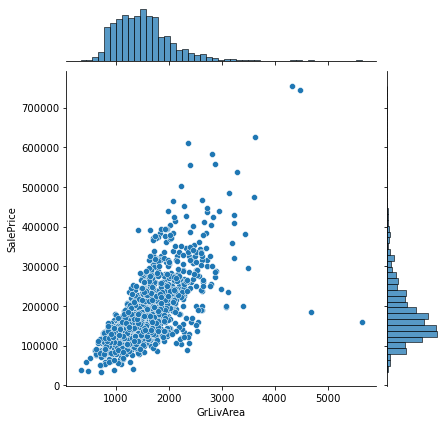

In [10]:
sns.jointplot(x = 'GrLivArea', y = 'SalePrice', data = data)

Visible correlation is disturbed by two points in the lower right corner, representing observations with huge Living Area, but relatively small Price. Deleting these would make my predictions more precise.

In [11]:
data.sort_values(by = 'GrLivArea', ascending = False)[:2]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750


In [12]:
data = data.drop(data.query('Id == 1299').index)

In [13]:
data = data.drop(data.query('Id == 524').index)

One cannot decide on how to treat a feature (as a numerical or categorical) only looking at the data type ('int64'/'float64' for numerical or 'object' for categorical). In current dataset similar notions are coded differently - for example 'OverallCond' and 'OverallQual' are 'int64', with order coded to numbers. However 'ExterQual' and 'ExterCond', 'BsmtQual' and 'BsmtCond', 'GarageQual' and 'GarageCond', 'KitchenQual', 'HeatingQC', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu' are type 'object', despite representing ordinal data. In some cases it is even more vague: 'Functional' represents levels of home functionality: from 'typical' to 'salvage only'. Same with 'GarageFinish' and 'Electrical'.
It is a matter of discussion how one should treat ordinal data, as numerical (continuous) or categorical (and loose the effect of ordering). Since we cannot be sure about equal distance between each level of the category, I choose to code the aforementioned variables as nominal.

In [14]:
data.OverallQual.dtypes, data.OverallCond.dtypes

(dtype('int64'), dtype('int64'))

In addition to 'OverallCond' and 'OverallQual' there's another categorical variable with 'wrong' type: 'MSSubClass' is 'int64'. It identifies the type of dwelling, for example 50: 1-1/2 STORY FINISHED ALL AGES. One should beware of treating it as numerical feature.

In [15]:
data.MSSubClass.dtypes, data.MSSubClass.unique()

(dtype('int64'),
 array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
        180,  40], dtype=int64))

Let's create a list of categorical features (including those with 'wrong' type and excluding those with lots of missing values) and examine them visually:

In [16]:
all_cat_features = [x for x in data.dtypes[data.dtypes == 'object'].index.tolist() 
                    if x not in ['Alley', 'PoolQC', 'Fence', 'MiscFeature']]
all_cat_features.extend(['MSSubClass', 'OverallQual', 'OverallCond'])

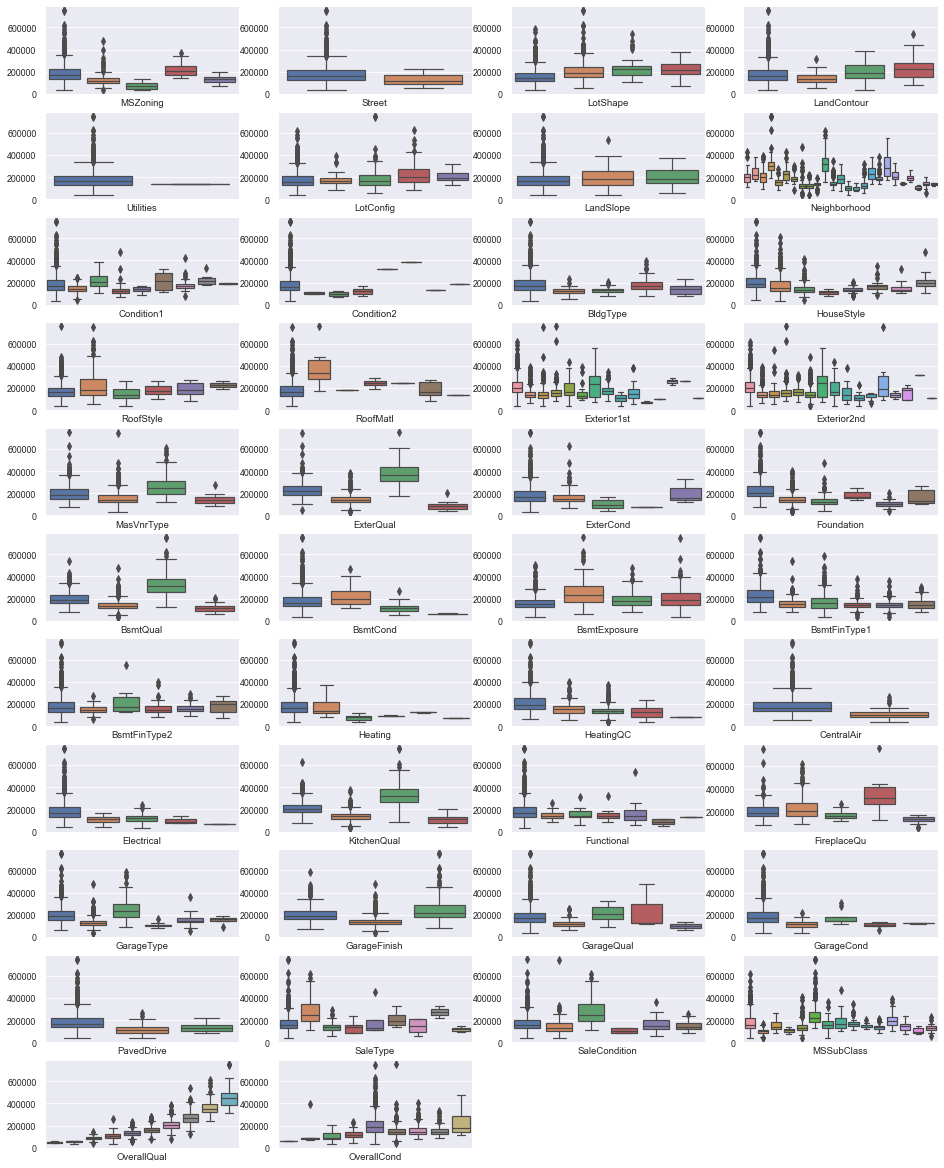

In [17]:
sns.set_theme(context='paper')
plt.figure(figsize=(16, 21))

for i in range(42):
    plt.subplot(11, 4, i+1)
    sns.boxplot(x=all_cat_features[i], y='SalePrice', data=data)
    plt.ylabel('')
    plt.xticks([])

plt.show()

Visual estimation of boxplots is not very precise, however I would get rid of some features with visually close medians and (partially) overlapping boxes. They are: 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'BsmtFinType2'

In [18]:
# delete more categorical features from the list
all_cat_features = [x for x in all_cat_features
                    if x not in ['Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'BsmtFinType2']]

In [19]:
all_cat_features

['MSZoning',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'SaleType',
 'SaleCondition',
 'MSSubClass',
 'OverallQual',
 'OverallCond']

I should concatenate train and test datasets now to perform the same actions on both parts.

In [20]:
test_data = pd.read_csv('C:/Users/Alex/Documents/тестовые задания/MacPawInternship/msi2021-data-science-main/data/test.csv')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [21]:
# I should keep in mind that after I deleted two observations, train-dataset is from 0 to 1457th row
data_full = pd.concat([data, test_data], ignore_index=True, sort=False)

Before we could feed the features to the model, the missing data should be handled. Let's check if there are any NA's in numerical features.

In [22]:
data_full[['GrLivArea', 'TotalBsmtSF', 'GarageArea', 'YearBuilt']].isna().sum()

GrLivArea      0
TotalBsmtSF    1
GarageArea     1
YearBuilt      0
dtype: int64

In case of numerical features I will later use SimpleImputer class from scikit-learn to complete missing values. In case of categorical features 'NA' not always means 'missing data', it means distinct category, for example BsmtQual: Evaluates the height of the basement: NA - No basement; therefore NAs here must be encoded appropriately. Same with FireplaceQu, 4 features describing the garage, and 3 more about the Basement('BsmtCond', 'BsmtExposure', 'BsmtFinType1'). The rest will be taken care of while performing One-Hot-Encoding (pandas.get_dummies function simply ignores nan).

In [23]:
for feature in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1'):
    data_full[feature] = data_full[feature].fillna('None')
data_full['FireplaceQu'] = data_full['FireplaceQu'].fillna('None')
for feature in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data_full[feature] = data_full[feature].fillna('None')

Create separate DataFrame and Perform One-Hot-Encoding for categorical features

In [44]:
cat_data_full = pd.DataFrame(data=data_full, columns=all_cat_features)
cat_data_full = cat_data_full.astype({'MSSubClass': 'object', 'OverallQual': 'object', 'OverallCond': 'object'})

In [45]:
cat_data_full = pd.get_dummies(cat_data_full, prefix_sep='_', drop_first=True)

In [46]:
cat_data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2917 entries, 0 to 2916
Columns: 221 entries, MSZoning_FV to OverallCond_9
dtypes: uint8(221)
memory usage: 629.7 KB


In [47]:
num_data_full = pd.DataFrame(data=data_full, columns=['GrLivArea', 'TotalBsmtSF', 'GarageArea', 'YearBuilt'])

Now I concatenate both dataframes into one, and leave out the 'test' part

In [48]:
data_ready = pd.concat([num_data_full, cat_data_full], axis=1)

In [49]:
train = data_ready.loc[0:1457, :]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Columns: 225 entries, GrLivArea to OverallCond_9
dtypes: float64(2), int64(2), uint8(221)
memory usage: 360.4 KB


To avoid data leakage I will employ pipeline for scaling and imputing missing data.
I will use Root Mean Squared Error (RMSE) to evaluate the model

In [50]:
def rmse_cv(model):
    return np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5)).mean()

In [51]:
X = train
y = np.log1p(data.SalePrice)

100%|██████████| 9/9 [00:20<00:00,  2.23s/it]


RMSE for alpha = 1 is 0.1342478120604805
RMSE for alpha = 15 is 0.1322586574477091
RMSE for alpha = 30 is 0.1313829396587118
RMSE for alpha = 45 is 0.13087240147217058
RMSE for alpha = 70 is 0.13040156120067276
RMSE for alpha = 90 is 0.13021416921962317
RMSE for alpha = 100 is 0.13016477783935582
RMSE for alpha = 125 is 0.13011986800798975
RMSE for alpha = 150 is 0.1301681181915954


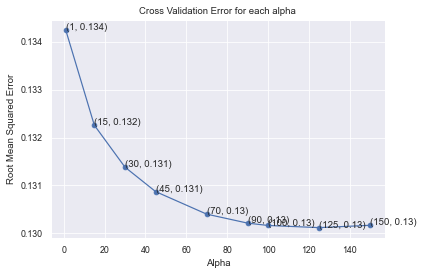

In [52]:
alpha = [1, 15, 30, 45, 70, 90, 100, 125, 150] 
# create list for storing scores to visualize different alphas
rmse_cv_values=[] 
for i in tqdm(alpha):
    ridge = Ridge(solver="sag", random_state=42, alpha=i)
    imputer = SimpleImputer(strategy='mean')
    pipeline = Pipeline([('imputer', imputer), ('scaler', StandardScaler()), ('ridge', ridge)])

    rmse_cv_values.append(rmse_cv(pipeline))

for i in range(len(rmse_cv_values)):
    print ('RMSE for alpha =', alpha[i], 'is', rmse_cv_values[i])

fig, ax = plt.subplots()
ax.plot(alpha, rmse_cv_values)
ax.scatter(alpha, rmse_cv_values)
for i, txt in enumerate(np.round(rmse_cv_values, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], rmse_cv_values[i]))

plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Root Mean Squared Error")
plt.show()

In [53]:
ridge = Ridge(solver="sag", random_state=42, alpha=125)
imputer = SimpleImputer(strategy='mean')
pipeline = Pipeline([('imputer', imputer), ('scaler', StandardScaler()), ('ridge', ridge)])

rmse_cv(pipeline)

0.13011986800798975

Seems like pretty decent result, but let's try Lasso linear model as well.

In [54]:
lasso = LassoCV(alphas = [1, 0.1, 0.01, 0.001, 0.0005]).fit(X, y)
imputer = SimpleImputer(strategy='mean')
pipeline = Pipeline([('imputer', imputer), ('scaler', StandardScaler()), ('lasso', lasso)])

rmse_cv(pipeline)

0.12460094876769374

Lasso performs better. Time to make predictions

In [55]:
X_test = data_ready[1458:]
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 1458 to 2916
Columns: 225 entries, GrLivArea to OverallCond_9
dtypes: float64(2), int64(2), uint8(221)
memory usage: 360.6 KB


In [56]:
# get rid of nan's in test dataset
X_test = SimpleImputer(strategy='mean').fit_transform(X_test)

Since I predicted logged target I should transform it back to get prices.

In [57]:
y_predict = np.floor(np.expm1(lasso.predict(X_test)))
y_predict

array([117023., 149775., 188118., ..., 153995., 124226., 221172.])

In [59]:
prediction = pd.DataFrame({'Id': test_data.Id, 'SalePrice': y_predict})
prediction.to_csv('prediction.csv', index=False)

But what if I dramatically reduce the number of categorical features and repeat all the steps again?

In [60]:
new_cat_features = ['Neighborhood', 'ExterQual', 'BsmtQual', 'KitchenQual', 'MSSubClass', 'OverallQual', 'OverallCond']
cat_data_full = pd.DataFrame(data=data_full, columns=new_cat_features)
cat_data_full = cat_data_full.astype({'MSSubClass': 'object', 'OverallQual': 'object', 'OverallCond': 'object'})
cat_data_full = pd.get_dummies(cat_data_full, prefix_sep='_', drop_first=True)

data_ready = pd.concat([num_data_full, cat_data_full], axis=1)

train = data_ready.loc[0:1457, :]
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 70 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GrLivArea             1458 non-null   int64  
 1   TotalBsmtSF           1458 non-null   float64
 2   GarageArea            1458 non-null   float64
 3   YearBuilt             1458 non-null   int64  
 4   Neighborhood_Blueste  1458 non-null   uint8  
 5   Neighborhood_BrDale   1458 non-null   uint8  
 6   Neighborhood_BrkSide  1458 non-null   uint8  
 7   Neighborhood_ClearCr  1458 non-null   uint8  
 8   Neighborhood_CollgCr  1458 non-null   uint8  
 9   Neighborhood_Crawfor  1458 non-null   uint8  
 10  Neighborhood_Edwards  1458 non-null   uint8  
 11  Neighborhood_Gilbert  1458 non-null   uint8  
 12  Neighborhood_IDOTRR   1458 non-null   uint8  
 13  Neighborhood_MeadowV  1458 non-null   uint8  
 14  Neighborhood_Mitchel  1458 non-null   uint8  
 15  Neighborhood_NAmes   

In [61]:
X = train
y = np.log1p(data.SalePrice)

100%|██████████| 8/8 [00:03<00:00,  2.11it/s]


RMSE for alpha = 1 is 0.13139652824785392
RMSE for alpha = 15 is 0.1313999321011396
RMSE for alpha = 30 is 0.13133696575980675
RMSE for alpha = 45 is 0.13136130965275078
RMSE for alpha = 70 is 0.131524095937592
RMSE for alpha = 90 is 0.13171528045256395
RMSE for alpha = 100 is 0.13182051067583192
RMSE for alpha = 150 is 0.13249100269160205


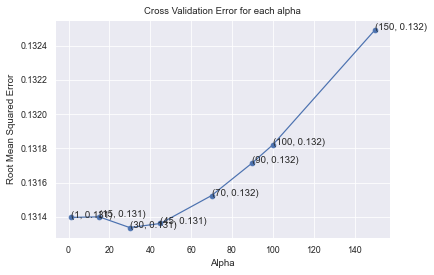

In [62]:
alpha = [1, 15, 30, 45, 70, 90, 100, 150] 
# create list for storing scores to visualize different alphas
rmse_cv_values=[] 
for i in tqdm(alpha):
    ridge = Ridge(solver="sag", random_state=42, alpha=i)
    imputer = SimpleImputer(strategy='mean')
    pipeline = Pipeline([('imputer', imputer), ('scaler', StandardScaler()), ('ridge', ridge)])

    rmse_cv_values.append(rmse_cv(pipeline))

for i in range(len(rmse_cv_values)):
    print ('RMSE for alpha =', alpha[i], 'is', rmse_cv_values[i])

fig, ax = plt.subplots()
ax.plot(alpha, rmse_cv_values)
ax.scatter(alpha, rmse_cv_values)
for i, txt in enumerate(np.round(rmse_cv_values, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], rmse_cv_values[i]))

plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Root Mean Squared Error")
plt.show()

In [63]:
lasso = LassoCV(alphas = [1, 0.1, 0.01, 0.001, 0.0005]).fit(X, y)
imputer = SimpleImputer(strategy='mean')
pipeline = Pipeline([('imputer', imputer), ('scaler', StandardScaler()), ('lasso', lasso)])

rmse_cv(pipeline)

0.13073660171255902

RMSE metric shows that both Ridge and Lasso models performed better on previous set of features.